<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/PersonalProjects/blob/main/FraudDetection_OnlinePayments/FraudDetection_OnlinePayments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection: Online Payments

In this file, I will build a fraud detection algorithm for a store that works with online payments. Fraud detection algorithms allow us to predict a probability of a given event being fraudulent, given some input parameters, and, thus, understand if more validation is necessary to conduct the transaction. To that end, we will go through the following steps:

1.   Data collection
2.   Data cleaning
3.   Data exploration and analysis
4.   Data modeling
5.   Optimization and Deployment

First, let's download and import the packages which will be used in this project.



In [1]:
# Installing a different pandas version to guarantee that it works with other packages on our project

!pip uninstall pandas -y
!pip install pandas==1.3.5

Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 13.0 MB/s 


In [2]:
# Installing a different pandas profilling version to guarantee that it works with other packages on our project

!pip uninstall pandas-profiling -y
!pip install pandas-profiling==3.1.0

Found existing installation: pandas-profiling 1.4.1
Uninstalling pandas-profiling-1.4.1:
  Successfully uninstalled pandas-profiling-1.4.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 13.0 MB/s 
     |████████████████████████████████| 690 kB 60.0 MB/s 
     |████████████████████████████████| 3.1 MB 28.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 102 kB 10.0 MB/s 
     |████████████████████████████████| 303 kB 54.4 MB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
     |████████████████████████████████| 812 kB 25.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=e338abd341dd919763dbd5d65e3eb211042d170e4e5573de0fe5139fcd766583
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d

In [3]:
# This package is required to apply SMOTE

!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 14.0 MB/s 
     |████████████████████████████████| 199 kB 61.9 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [4]:
# Catboost model

!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [5]:
import pandas as pd                                           # Data collection and manipulation
import numpy as np                                            # Work with arrays
import random                                                 # For randomized operations

from pandas_profiling import ProfileReport                    # Assists in data exploration

import matplotlib.pyplot as plt                               # Data visualization
import seaborn as sns                                         # Data visualization
%matplotlib inline

# Modeling

from sklearn.model_selection import train_test_split          # Train-test split
from imblearn.over_sampling import SMOTE                      # SMOTE algorithm for oversampling

from sklearn.dummy import DummyClassifier                     # Dummy classifier
from sklearn.linear_model import LogisticRegression           # Logistic regression
from sklearn.tree import DecisionTreeClassifier               # Decision tree
from sklearn.ensemble import RandomForestClassifier           # Random forest
from sklearn.ensemble import GradientBoostingClassifier       # Gradient boosting
from xgboost import XGBClassifier                             # XGBoost
from catboost import CatBoostClassifier                       # Catboost

# Model validation

from sklearn import metrics                                   # Metrics for comparing different models
from sklearn.metrics import confusion_matrix                  # Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay            # Confusion matrix plot

# Model optimization

from sklearn.model_selection import RandomizedSearchCV        # Randomized search cross-validation

# Model deploy

import pickle                                                  # Model serialization
from ipywidgets import widgets, HBox, VBox                     # Interactive simulator
from IPython.display import display                            # Simulator display

So, let's start with collecting the data.

# Data collection

The data we are using in this work was taken from Kaggle:

https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

Since the dataset is very large, we will perform analysis, manipulation, modeling, and testing over a smaller dataset containing "only" 500,000 entries. Let's import it using Pandas:

In [6]:
raw_df = pd.read_csv('Dataset_Kaggle_FDOP_Cut_500000.csv', sep = ';', nrows = 500000)

In [7]:
raw_df.head( )

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Nice. So, in this dataset,we have the following columns:

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction
* isFlaggedFraud: the business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

For modeling, we will likely drop the following features: step, nameOrig, nameDest. These features say very little about the transaction, and will only create noise in our model. Through exploratory analysis, we will also see if there is any other feature worth dropping.

# Data cleaning

Data cleaning is a very important step to remove some undesirable data from our dataset. First, let's see if there is any missing value:

In [8]:
raw_df.isnull( ).sum( )

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Nice! We have no missing entries in our dataset. That's great. Now, let's see if we have any duplicated entry:

In [9]:
raw_df.duplicated( ).sum( )

0

We also have no duplicated entries!

Now, let's check the typing of our data:

In [10]:
raw_df.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB


Note that the type feature is of the object typing. It is a good practice to transform it into a numeric value by mapping each category to a integer. First, let's analyze the feature:

In [11]:
raw_df['type'].head(10)

0     PAYMENT
1     PAYMENT
2    TRANSFER
3    CASH_OUT
4     PAYMENT
5     PAYMENT
6     PAYMENT
7     PAYMENT
8     PAYMENT
9       DEBIT
Name: type, dtype: object

This feature stores the type of transaction being made. Note that there is no hierarchy in our data. Thus, using a label encoder would likely introduce an undesirable relationship between these classes. Instead, we can create binary dummy features for each type. First, let's see the unique values on this feature:

In [12]:
raw_df['type'].unique( )

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

Ok, so we have 5 possible outcomes. Thus, we will create 5 new binary dummy features for each outcome, and remove the type feature. We can do this using Pandas:

In [13]:
df = pd.get_dummies(data = raw_df, columns = ['type'])

df.head( )

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


Nice. Now, instead of a type features, we have five other dummy features which will be used in our model. 

Finally, we already discussed that we should drop the features 'step, 'nameOrig', and 'nameDest' since they contribute very little to what we aim to do. We can do this using: 

In [14]:
dropped_cols = ['step', 'nameOrig', 'nameDest']

df.drop(dropped_cols, axis = 1, inplace = True)

df.head( )

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


Ok, now, let's continue our work into the Data Exploratory Analysis (EDA).

# Data exploration and analysis

This stage is very important to understanding the patterns in our dataset. This is very important so we know which model we need to employ, and to understand if we need to perform any additional treatment in our data.

First, let's create a function to plot a countplot with information about the percentual of each class. We can do that using:

In [15]:
def plot_perc(feature, dataset):
  plt.figure(figsize = (16, 6))
  g = sns.countplot(x = feature, data = dataset, orient = 'h')

  g.set_ylabel('Count', fontsize = 18)

  sizes = []
  for p in g.patches:
    height = p.get_height( )
    sizes.append(height)
    g.text(p.get_x( ) + p.get_width( )*0.2, 
           height, 
           '{:1.2f}%'.format(height/len(dataset)*100),
           ha = 'center', va = 'bottom', fontsize = 12)
    
  g.set_ylim(0, max(sizes)*1.1)

So, we want to make a model to predict if a given transaction is fraudulent or not. In our dataset, this can be found in feature ```isFraud```, which is 0 for a non-fraudulent transaction, and 1 for a fraudulent transaction. Let's understand how many entries we have for each class:

In [16]:
df.isFraud.value_counts( )

0    499767
1       233
Name: isFraud, dtype: int64

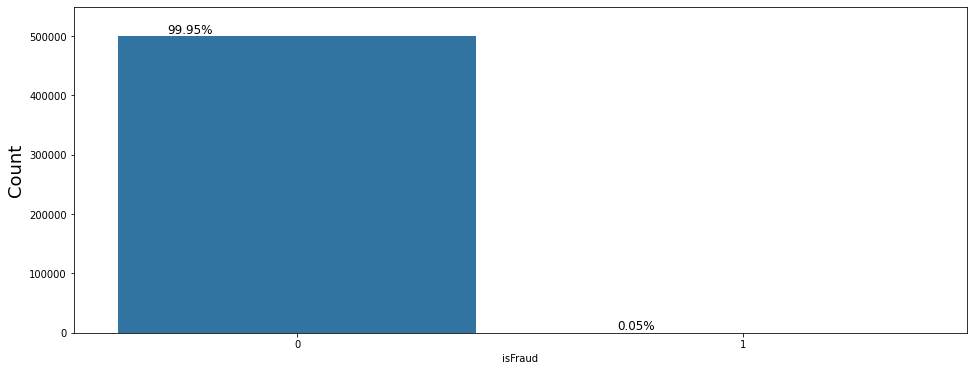

In [17]:
plot_perc('isFraud', df)

So, in our dataset, 499767 entries are from non-fraudulent transactions, while only 233 entries are fraudulent transactions. Still, we have to worry about those transactions, because there is a lot of money involved in them:

In [18]:
amount_fraud = df.loc[df.isFraud == 1, 'amount'].sum( )

print(f"Fraudulent amount: {amount_fraud}")

Fraudulent amount: 194065817.95999998


Thus, it is **VERY** important that we are able to correctly predict fraudulent transactions (or at least have a good guess on what transactions are more likely fraudulent).

Also, the amount of money involved in fraudulent data is, on average, higher than the amount of money for non-fraudulent data:

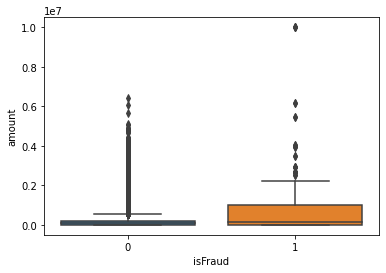

In [19]:
sns.boxplot(x = 'isFraud', y = 'amount', data = df)

In [20]:
group_fraud = df.groupby('isFraud')
group_fraud['amount'].describe( )

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,499767.0,166082.951021,2.698829e+05,0.1,13347.025,81357.1,222576.925,6419835.27
1,233.0,832900.506266,1.668775e+06,119.0,20128.000,143032.0,994453.200,10000000.00


Thus, on average, fraudulent transactions involve five times more money!

In [21]:
print(f"Fraudulent transactions involve {round(group_fraud['amount'].mean( )[1]/group_fraud['amount'].mean( )[0], 2)} times more money (on average)!")

Fraudulent transactions involve 5.01 times more money (on average)!


Also, it is interesting to note that ALL of our frauds are from transfer and cash out types (almost a 50-50 split):

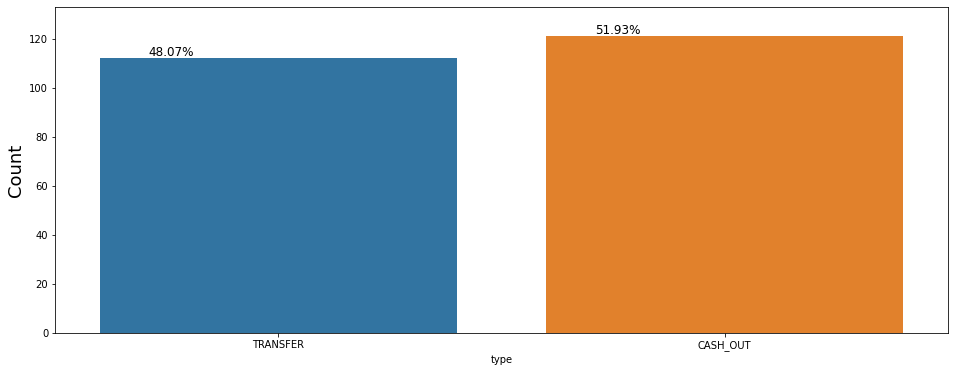

In [22]:
raw_df_fraud = raw_df.query("isFraud == 1")

plot_perc('type', raw_df_fraud)

Now, let's understand how our features are related to each other. First, let's draw a pairplot for the old and new balances of the transaction participants:

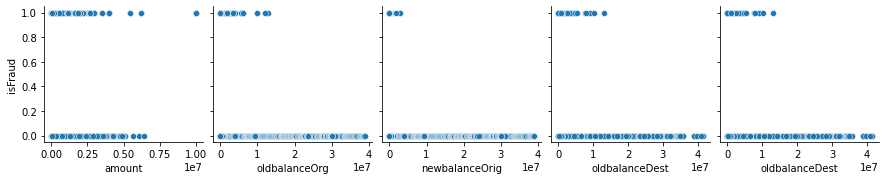

In [23]:
sns.pairplot(df, x_vars = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'oldbalanceDest'], y_vars = ['isFraud'])

Note that, while the amount of cash involved is usually higher in frauds, the balance of the participant is usually lower than the average. This is a very interesting conclusion, and and will help us to better guide the company with good suggestions later on. We can also see this by getting the mean for this features:

In [24]:
group_fraud[['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].mean( )

,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
isFraud,,,,
0,911730.255755,931848.846770,983046.846843,1.162774e+06
1,831403.000258,23747.261974,408801.853519,9.457514e+05


Now, let's plot a correlation matrix of our entire dataset, to check how are our features correlated. We can do that using a heat map:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


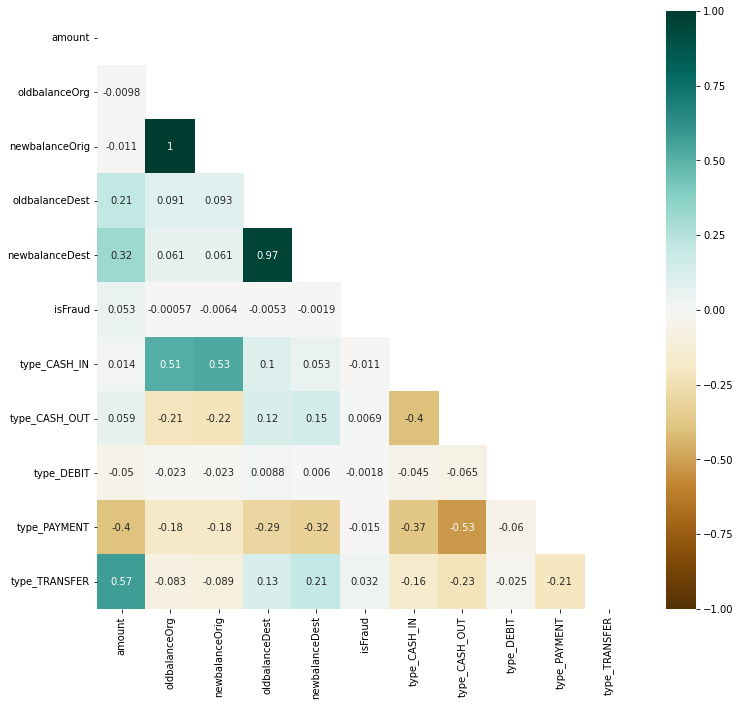

In [25]:
plt.figure(figsize=(12, 11))

mask = np.triu(np.ones_like(df.drop('isFlaggedFraud', axis = 1).corr(), dtype=np.bool))

heatmap = sns.heatmap(df.drop('isFlaggedFraud', axis = 1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

So, let's discuss some important things: First, there is a very strong correlation between "newbalanceOrig" and "oldbalanceOrg", and between "oldbalanceDest" and "newbalanceDest". This is expected since these features say basically the same information, but in different moments of time (before and after the transaction). 

Regarding the transaction types, there is a high correlation between type_TRANSFER and amount. This is likely because on transfer transactions there is usually a higher amount involved: 

In [26]:
group_transfer = df.groupby('type_TRANSFER')

group_transfer['amount'].mean( )

type_TRANSFER
0    120007.576545
1    689441.795265
Name: amount, dtype: float64

Note that the average for the other types is 120007, while the average of type_TRANSFER is 689441! It is important to remember that type_TRANSFER is actually one of the "important" types, since all fraud transactions occur either on TRANSFER or CASH_OUT! We can also see this using scatterplots or, even better, a boxplot:

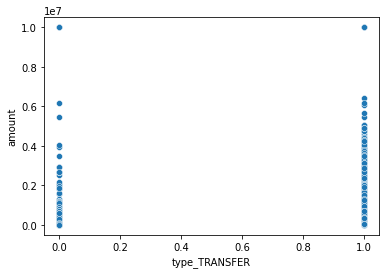

In [27]:
sns.scatterplot(x = 'type_TRANSFER', y = 'amount', data = df)

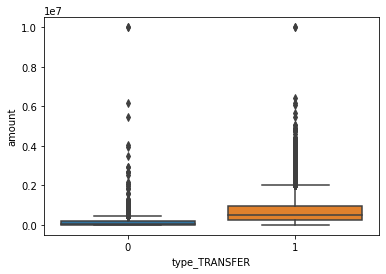

In [28]:
sns.boxplot(x = 'type_TRANSFER', y = 'amount', data = df)

Finally, we have a second feature named isFlaggedFraud which stores transactions with ```amount > 200000```. Let's check how many of those there are:

In [29]:
df.isFlaggedFraud.sum( )

0

So, actually, all entries in this feature have the same value (0). Thus, we can actually drop it from our dataset. 

Before going to the next topic, let's make a profile report, and check if there is any other aspect that we couldn't identify through our analysis:

In [30]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It seems that we have already identified most of our data features. Note that, here, we found some duplicated entries. However, this is due to the removal of some primary keys ('step', 'nameOrig', 'nameDest'). Here, we will leave those entries in the dataset. 

## Return to data cleaning

So, we have finished our data exploration, and we stated that we should actually remove one feature since it is actually giving us no information about our data. So, let's return to data cleaning and remove it from our dataset:

In [31]:
df.drop('isFlaggedFraud', axis = 1, inplace = True)

Nice! Now, we can continue to the next phase: modeling.

# Data modeling

Nice! Now that we have finished our data cleaning and exploration, we can finally go to data modeling!

So, we want to **classify** if a given entry is fraudulent or not. That means that we should apply a classification algorithm to our data. These algorithms allow us to evaluate a probability of a binary event occurring and, by considering a threshold (which is usually 0.50), we can classify our entries.

First, we will start by separating our data into targets and independent variables, and then into train and test splits. Then, we will create some baseline models for us to compare with. Later, we will compare different more robust models to understand which model is the best for our application.

## Train-test split

To make our train-test split, we can do:

In [32]:
X = df.drop('isFraud', axis = 1) # Independent variables
y = df.isFraud                   # Target variable

SEED = 1001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

## First tries at modeling

Here, we will go through some tests using simple modeling criteria. 



### Dummy classifier

Our first test will be using a dummy classifier, where our model always guesses the class which is most frequent in our dataset. We can do this by:



In [33]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

We can get the model prediction in the test set using:

In [34]:
y_pred = dummy_clf.predict(X_test)

Nice! Now, let's get some metrics. For classification models, there are some very important metrics, usually related to the True Positives ($TP$), True Negatives ($TN$), False Positives ($FP$), and False Negatives ($FN$). These are:

* Accuracy: The accuracy evaluates the division between correctly guessed entries, and the total number of entries.

\begin{equation}
\dfrac{TN + TP}{TN + TP + FN + FP}
\end{equation}

* Precision: Precision evaluates the proportion of $TP$ in relation to the positive predictions from the model. If we have low precision, it means that there are a lot of non-frauds that our model is identifying as frauds.

\begin{equation}
\dfrac{TP}{TP + FP}
\end{equation}

* Recall: Recall evaluates the proportion of $TP$ and the number of positives from the test set. If we have a lower recall, it means that we are letting many frauds pass.

\begin{equation}
\dfrac{TP}{TP + FN}
\end{equation}

* F1-score: Tries to balance precision and recall. It goes from 0 to 1, and the closest it is to 1, the better.

\begin{equation}
2 \, \dfrac{P \, R}{P + R}
\end{equation}

The number of $TN$, $TP$, $FN$, and $FP$ can be easily checked in the confusion matrix:

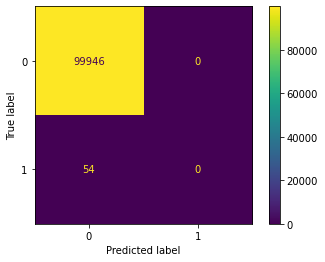

In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format='d')

Our model had 99946 True Negatives ($TN$) and 54 False Negatives ($FN$). At a first glance, our model may seem very good. Let's evaluate our metrics:

In [36]:
acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(metrics.precision_score(y_test, y_pred), 4)
rec = round(metrics.recall_score(y_test, y_pred), 4)
f1s = round(metrics.f1_score(y_test, y_pred), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.9995
Precision : 0.0
Recall    : 0.0
F1        : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note that, while our dummy classifier showed an accuracy of 99.95%, it showed a precision and a recall of 0%! That occured because our model predicted that, in our dataset, there is no fraudulent entry! On unbalanced datasets, the accuracy can pass the worng idea that our model is better than it really is. In these cases, we really want to look for precision and, especially, recall. **Recall tells us the percentage of fraudulent entries our model was able to identify. Thus, by having a higher recall, we become less likely to allow a fradulent transaction**.

Before trying to fit a slightly better model, let's also plot the ROC curve and evaluate the AUC:

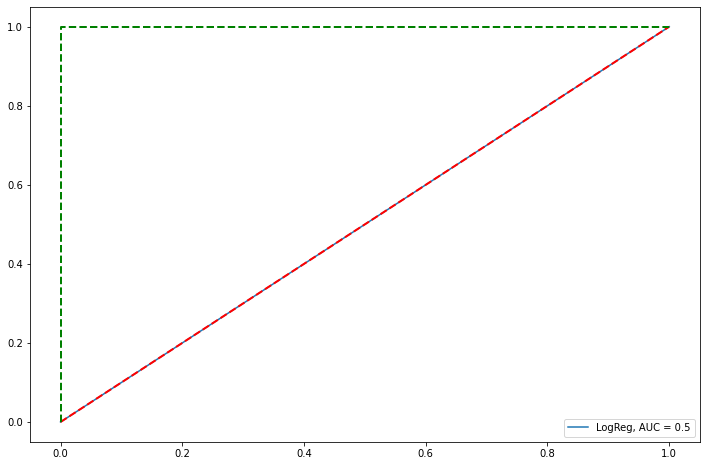

In [37]:
y_pred_proba = dummy_clf.predict_proba(X_test)[::, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig = plt.figure(figsize = (12, 8))

plt.plot(fpr, tpr, label = 'LogReg, AUC = '+str(auc))
plt.plot([0, 1], [0, 1], color = 'r', lw = 2, linestyle = '--')
plt.legend(loc = 'best')

plt.plot([0, 0, 1], [0, 1, 1], color = 'g', lw = 2, linestyle = '--')

Note that our $AUC = 0.5$ and our dummy classifier is actually a straight diagonal, which goes from (0, 0) to (1, 1). This mean that our classifier is no better than a random model.

So, it is clear that we actually need a better model for our data. However, the dummy classifier gives us a nice baseline for us to improve upon. Before jumping to other models, let's just store the metrics for the dummy classifier in a dataframe:

In [38]:
df_metrics = pd.DataFrame( {'acc' : acc, 'prc' : prc, 'rec' : rec, 'f1s' : f1s, 'auc' : auc }, index = ['Dummy classifier'] )
df_metrics

,acc,prc,rec,f1s,auc
Dummy classifier,0.9995,0.0,0.0,0.0,0.5


Nice! We will later use this table to compare our models more easily.

### Logistic regression

Now, let's try to use a "real" model for fraud detection. For that end, we will try to use a simple logistic regression model. Thus, we can do:

In [39]:
model_LogReg = LogisticRegression(max_iter = 1000, random_state = SEED)

model_LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1001)

We can evaluate the prediction (and the probability associated) with:

In [40]:
y_pred = model_LogReg.predict(X_test)

Now, let's plot the confusion matrix and get the metrics associated with it:

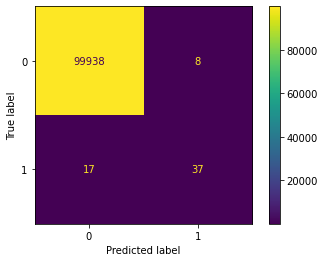

In [41]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format = 'd')

In [42]:
acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(metrics.precision_score(y_test, y_pred), 4)
rec = round(metrics.recall_score(y_test, y_pred), 4)
f1s = round(metrics.f1_score(y_test, y_pred), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.9998
Precision : 0.8222
Recall    : 0.6852
F1        : 0.7475


Nice! This time, our model was *at least* able to find some frauds. Our accuracy was slightly higher, but we are concerned more with the other metrics. Precision is 82.22%, which means that 17.78% of the positives from our model are, indeed, positives, and our recall is 68.52%. This means that only 31.48% of the fraudulent entries were ignored. That is a very big improvement from our initial model, but it is still far from ideal.

Let's analyze the ROC curve:

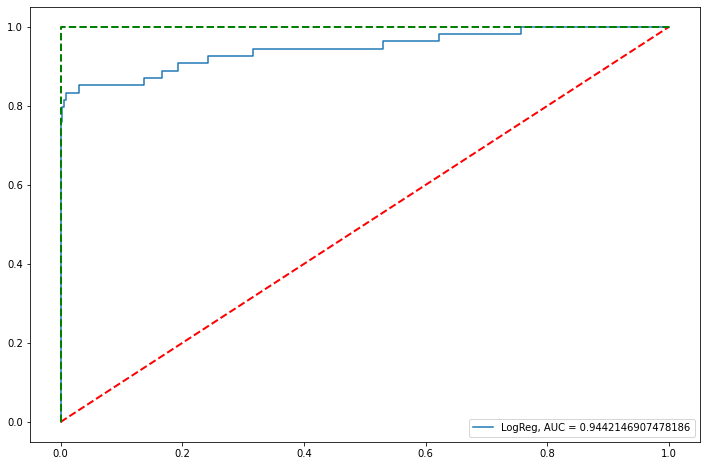

In [43]:
y_pred_proba = model_LogReg.predict_proba(X_test)[::, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig = plt.figure(figsize = (12, 8))

plt.plot(fpr, tpr, label = 'LogReg, AUC = '+str(auc))
plt.plot([0, 1], [0, 1], color = 'r', lw = 2, linestyle = '--')
plt.legend(loc = 'best')

plt.plot([0, 0, 1], [0, 1, 1], color = 'g', lw = 2, linestyle = '--')

Again, the ROC curve is much better than the previous example. Note that the recall curve compares the True Positive Rate (which is the same as the recall) and the True Negative Rate. 

The fact is, in problems where our data is not balanced, the ROC curve may have a problem similar to the accuracy, and the area under the curve may give a wrong idea about our model. 

For problems where our data is not balanced, we can instead use a precision-recall curve:

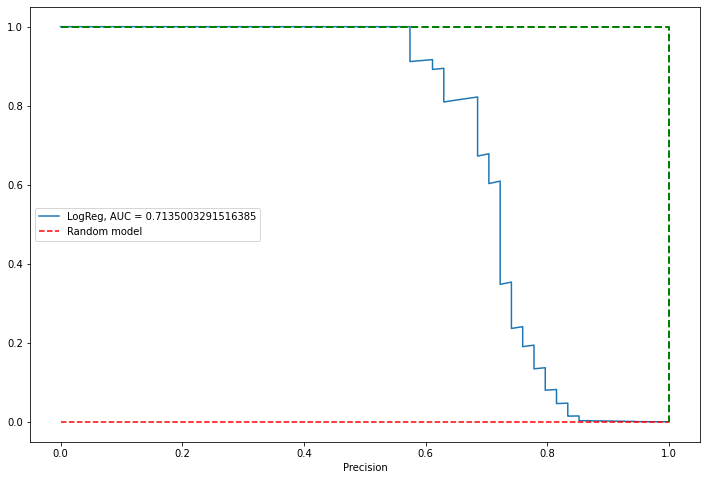

In [44]:
y_pred_proba = model_LogReg.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'LogReg, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'Random model')
plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.xlabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

Nice! This graph is much more adequate for the type of problem we are dealing with. Let's store our results in our metrics dataframe:

In [45]:
df_metrics.loc['Logistic Regression 1'] = [acc, prc, rec, f1s, auc]

In [46]:
df_metrics

,acc,prc,rec,f1s,auc
Dummy classifier,0.9995,0.0000,0.0000,0.0000,0.5000
Logistic Regression 1,0.9998,0.8222,0.6852,0.7475,0.7135


Note that we also have to update the Area Under the Curve for the Dummy Classifier with the AUC from the Precision-Recall curve. Thus, we can do:

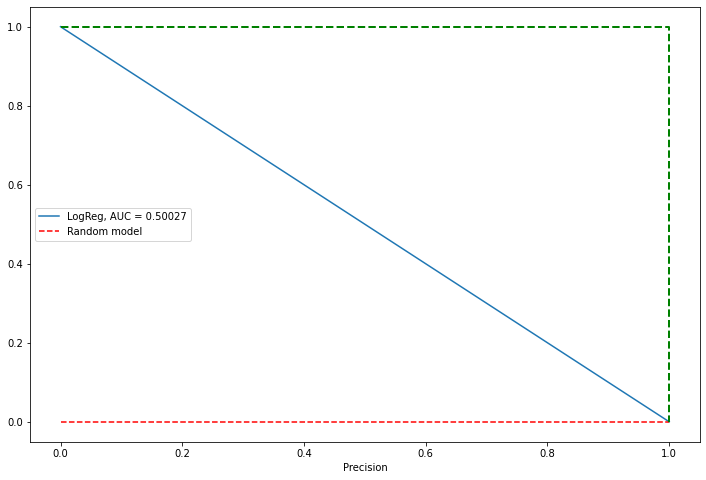

In [47]:
y_pred_proba = dummy_clf.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'LogReg, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'Random model')
plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.xlabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

In [48]:
df_metrics.iloc[0, -1] = auc
df_metrics

,acc,prc,rec,f1s,auc
Dummy classifier,0.9995,0.0000,0.0000,0.0000,0.50027
Logistic Regression 1,0.9998,0.8222,0.6852,0.7475,0.71350


Nice!

So, using our logistic regression model, we were able to get a recall of 77.27%. Even though this was a great improvement over our first model, some of the fraudulent entries are still being ignored by our model. 

One thing we can improve is that our dataset has very few fraudulent entries. Thus, it is hard to fit a model to detect frauds, since there is very few fraudulent transactions in our data. 

To handle this, we can use to different techniques: undersampling, where the number of data from the majority class is decreased, and oversampling, where the number of data from the minority class is increased.

## Oversampling

Here, to guarantee that we will not lose any data from our dataset, we will use oversampling. The inclusion of new fraudulent data will be made with the SMOTE algorithm, where a K-Means algorithm is used to identify patterns in the data, and then new data from the minority class is generated using these patterns.

We can apply SMOTE using:

In [49]:
smote = SMOTE(sampling_strategy = 0.1, random_state = SEED)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

Nice! We only oversampled the training set, since we will use the same test set as before (to guarantee that our comparisons are fair). Now, we can get our oversampled dataset using:

In [50]:
df_over = pd.concat([y_train_over, X_train_over], axis = 1)

Now, the number of fraudulent entries is 10% of the number of non-fraudulent entries:

In [51]:
df_over.isFraud.value_counts( )

0    399821
1     39982
Name: isFraud, dtype: int64

SMOTE uses similarity-based techniques to generate the new data. For instance, previously, we saw that all of our frauds actually came from two transaction types: transfers and cash-outs. Let's try to analyze the same thing from our oversampled dataset:

In [52]:
over_df_fraud = df_over.query("isFraud == 1")

over_df_fraud[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum( )

type_CASH_IN         0
type_CASH_OUT    17875
type_DEBIT           0
type_PAYMENT         0
type_TRANSFER    16938
dtype: int64

Again, all of our frauds are from the TRANSFER and CASH_OUT types!

**That being said, by using an oversampling technique, we may introduce some information in our dataset which does not represent the real data. Thus, we should use this alternative with caution (as well as undersampling). To reduce the amount of "noise" introduced, we can try to oversample our minority class only to a fraction of the majority class (such as 10%). We can do that using the ```sampling_strategy = 0.1``` parameter from SMOTE. That is why we considered this in this example.**

## Returning to the Logistic Regression

Ok, now, let's fit our logistic regression model again, now to oversampled data:

In [53]:
model_LogReg = LogisticRegression(max_iter = 1000, random_state = SEED)

model_LogReg.fit(X_train_over, y_train_over)

LogisticRegression(max_iter=1000, random_state=1001)

Let's perform the prediction on the test set (note that the test set is not oversampled):

In [54]:
y_pred = model_LogReg.predict(X_test)

Now, let's plot the confusion matrix, get the metrics, and plot the precision-recall curve:

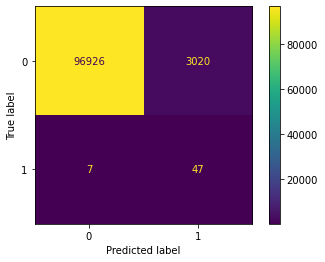

In [55]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot( )

In [56]:
acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(metrics.precision_score(y_test, y_pred), 4)
rec = round(metrics.recall_score(y_test, y_pred), 4)
f1s = round(metrics.f1_score(y_test, y_pred), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.9697
Precision : 0.0153
Recall    : 0.8704
F1        : 0.0301


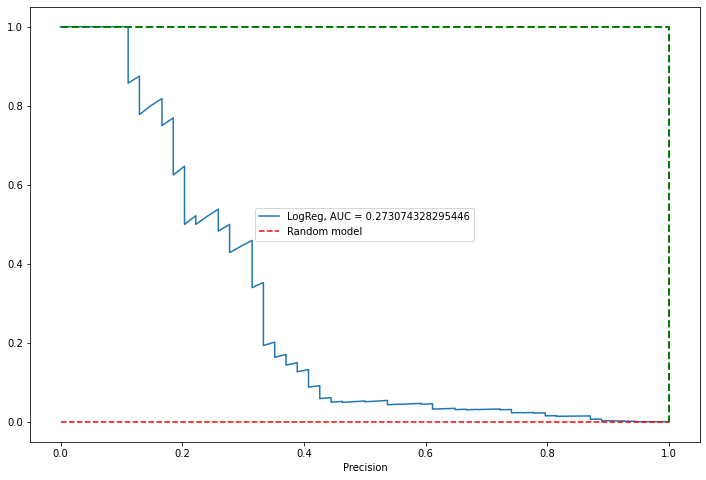

In [57]:
y_pred_proba = model_LogReg.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'LogReg, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'Random model')
plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.xlabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

In [58]:
df_metrics.loc['Logistic Regression 2'] = [acc, prc, rec, f1s, auc]

In [59]:
df_metrics

,acc,prc,rec,f1s,auc
Dummy classifier,0.9995,0.0000,0.0000,0.0000,0.500270
Logistic Regression 1,0.9998,0.8222,0.6852,0.7475,0.713500
Logistic Regression 2,0.9697,0.0153,0.8704,0.0301,0.273074


Using SMOTE, we actually managed to increase our recall to 87.04%. Now, our model is only missing 12.96% of the fraudulent transactions. However, note that our model now has a very poor precision and AUC. That occurs because, using SMOTE, our model may end up *thinking* that frauds are actually much more likely than they really are. Thus, it ends up predicting a lot more frauds. We can also see this by analyzing the confusion matrix. 

Now, can we improve our model even further? Well, we can try to use *other* models.

## Testing out more robust models

This time, we will try to use other modeling criteria, namely:

*   Decision tree
*   Random forest
*   Gradient boosting
*   Catboost
*   XGBoost

Since we really want to try and detect frauds, we will use the **recall** to compare these models. Thus, let's create a user defined function to fit a model a store the metrics in our metrics dataframe:

In [60]:
def GetModelMetrics( X_train, X_test, y_train, y_test, classifier, dataset_for_metrics ):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  y_pred_proba = classifier.predict_proba(X_test)[::, 1]
  prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)

  acc = round(metrics.accuracy_score(y_test, y_pred), 4)
  prc = round(metrics.precision_score(y_test, y_pred), 4)
  rec = round(metrics.recall_score(y_test, y_pred), 4)
  f1s = round(metrics.f1_score(y_test, y_pred), 4)
  auc = round(metrics.auc(recr, prcr), 4)

  dataset_for_metrics.loc[classifier.__class__.__name__] = [acc, prc, rec, f1s, auc]

Nice! Now, let's instance our models:

In [61]:
model_DcTree = DecisionTreeClassifier(max_depth = 5, random_state = SEED)
model_RndFor = RandomForestClassifier(max_depth = 5, n_estimators = 100, random_state = SEED)
model_GrdBst = GradientBoostingClassifier(random_state = SEED)
model_CatBst = CatBoostClassifier(loss_function='Logloss', verbose = False, random_state = SEED)
model_XtGBst = XGBClassifier(n_estimators = 300, seed = SEED)

In [62]:
models = [model_DcTree, model_RndFor, model_GrdBst, model_CatBst, model_XtGBst]

Nice! Now, we can get the metrics for each model using:

In [63]:
for model in models:
  GetModelMetrics(X_train_over, X_test, y_train_over, y_test, model, df_metrics)

Note that, since we are mostly worried about recall in this example, we still used the oversampled training set, even though it reduced our precision. Now, let's see our metrics for each model:

In [64]:
df_metrics.sort_values(by = 'rec', ascending = False)

,acc,prc,rec,f1s,auc
Logistic Regression 2,0.9697,0.0153,0.8704,0.0301,0.273074
XGBClassifier,0.9964,0.1063,0.7778,0.1871,0.598300
CatBoostClassifier,0.9983,0.2103,0.7593,0.3293,0.661500
GradientBoostingClassifier,0.9961,0.0964,0.7407,0.1706,0.525800
Logistic Regression 1,0.9998,0.8222,0.6852,0.7475,0.713500
DecisionTreeClassifier,0.9992,0.3418,0.5000,0.4060,0.356600
RandomForestClassifier,0.9994,0.4500,0.5000,0.4737,0.487900
Dummy classifier,0.9995,0.0000,0.0000,0.0000,0.500270


So, the Logistic Regression actually got the highest recall out of the tested models. Thus, we could choose it!

### Improving our way of choosing models

Now, we have to keep something in mind. Let's say we have a dummy classifier which actually always chooses the **minority class**. Then, we would have a classifier with a very low accuracy and precision. However, our recall would be 100%. Thus, by going only with the recall, we may lead to models with a very poor capability of predicting new values. 

An idea would be to use the $f_1$ score to get the best model, as this score balances the precision and the recall. However, we actually want to prioritize recall. 

Another important point: all of our models evaluate the probability of each class and, by default, they consider a probability threshold of 50% to pick the correct class for each entry. However, this may not be the optimal threshold. We can actually use the Precision-Recall curve to get this optimal threshold. However, if we only take the recall in consideration, we will always fall into considering that all data is fraudulent, as this leads to a recall of 100%.

A very simple thing we can do is create an auxiliary metrics which is:

\begin{equation}
M_{PR} = R \text{, if $P > P_t$}
\end{equation}

\begin{equation}
M_{PR} = 0 \text{, otherwise}
\end{equation}

where $P$ is the precision and $R$ is the recall. 

Thus, by considering a minimum $P_t$, we guarantee that our model has at least some precision. We can evaluate our new metric by:

In [65]:
def calc_mpr(rec, prc, pt):
  mpr = rec
  if prc < pt:
    mpr = 0.0
  return mpr

def add_mpr_to_df(index_name, pt, df_mt):
  prc = df_mt.loc[index_name, 'prc']
  rec = df_mt.loc[index_name, 'rec']
  mpr = calc_mpr(rec, prc, pt)
  df_mt.loc[index_name, 'mpr'] = mpr

In [66]:
pt = 0.10

for index_name in df_metrics.index:
  add_mpr_to_df(index_name, pt, df_metrics)

Now, let's see the $M_{pr}$ for our classifiers:

In [67]:
df_metrics.sort_values(by = 'mpr', ascending = False)

,acc,prc,rec,f1s,auc,mpr
XGBClassifier,0.9964,0.1063,0.7778,0.1871,0.598300,0.7778
CatBoostClassifier,0.9983,0.2103,0.7593,0.3293,0.661500,0.7593
Logistic Regression 1,0.9998,0.8222,0.6852,0.7475,0.713500,0.6852
DecisionTreeClassifier,0.9992,0.3418,0.5000,0.4060,0.356600,0.5000
RandomForestClassifier,0.9994,0.4500,0.5000,0.4737,0.487900,0.5000
Dummy classifier,0.9995,0.0000,0.0000,0.0000,0.500270,0.0000
Logistic Regression 2,0.9697,0.0153,0.8704,0.0301,0.273074,0.0000
GradientBoostingClassifier,0.9961,0.0964,0.7407,0.1706,0.525800,0.0000


Now that we penalized models with very low precision, our best model is actually the XGBoost!

Now, let's try to improve our validation a little more. All of our models evaluate the probability of each class and, by default, they consider a probability threshold of 50% to pick the correct class for each entry. However, this may not be the optimal threshold. We can actually use the Precision-Recall curve to get this optimal threshold.

Here, we will ignore the dummy classifier. So, we will just add its optimal threshold as:



In [68]:
df_metrics.loc['Dummy classifier', 'threshold'] = 0.50

Now, let's try to get the optimal threshold for our Logistic Regression 1 model. First, let's fit it again and get its prediction and prediction probability:

In [69]:
model_LogReg = LogisticRegression(max_iter = 1000, random_state = SEED)

model_LogReg.fit(X_train, y_train)

y_pred = model_LogReg.predict(X_test)
y_pred_proba = model_LogReg.predict_proba(X_test)[::, 1]

Now, let's get the precision recall curve:

In [70]:
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)

Note that, by doing this, we get the precision and recall for different thresholds. Now, let's simply get the $M_{pr}$ for each point of the precision recall curve, and get the threshold associated with it:

In [71]:
def calc_mpr_list(recr, prcr, pt):
  mpr_list = []
  for i in range(len(recr)):
    mpr_list.append(calc_mpr(recr[i], prcr[i], pt))
  return mpr_list

In [72]:
mprr = calc_mpr_list(recr, prcr, pt)

In [73]:
max_index = np.where(mprr == np.amax(mprr))

opt_threshold = threshold[max_index][0]

opt_threshold

0.456788111519547

In this case, the optimum threshold is 0.4567, which finds a $M_{pr}$ of 0.7963:

In [74]:
np.amax(mprr)

0.7962962962962963

Ok, let's add this information to our metrics df:

In [75]:
opt_mpr = mprr[max_index[0][0]]
opt_rec = recr[max_index[0][0]]
opt_prc = prcr[max_index[0][0]]
opt_f1s = 2*((opt_prc*opt_rec)/(opt_prc+opt_rec))

df_metrics.loc['Logistic Regression 1', 'threshold'] = opt_threshold
df_metrics.loc['Logistic Regression 1', 'mpr']       = opt_mpr
df_metrics.loc['Logistic Regression 1', 'rec']       = opt_rec
df_metrics.loc['Logistic Regression 1', 'prc']       = opt_prc
df_metrics.loc['Logistic Regression 1', 'f1s']       = opt_f1s

Now, let's do a similar approach to get the optimum threshold and the accuracy metrics for the other methods. First, let's redefine our user defined function:

In [76]:
def GetModelMetrics( X_train, X_test, y_train, y_test, classifier, dataset_for_metrics ):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  y_pred_proba = classifier.predict_proba(X_test)[::, 1]
  prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
  mprr = calc_mpr_list(recr, prcr, pt)

  max_index = np.where(mprr == np.amax(mprr))
  opt_threshold = threshold[max_index][0]
  opt_mpr = mprr[max_index[0][0]]
  opt_rec = recr[max_index[0][0]]
  opt_prc = prcr[max_index[0][0]]
  opt_f1s = 2*((opt_prc*opt_rec)/(opt_prc+opt_rec))

  acc = round(metrics.accuracy_score(y_test, y_pred), 4)
  prc = round(opt_prc, 4)
  rec = round(opt_rec, 4)
  f1s = round(opt_f1s, 4)
  auc = round(metrics.auc(recr, prcr), 4)
  mpr = round(opt_mpr, 4)
  thr = round(opt_threshold, 4)

  dataset_for_metrics.loc[classifier.__class__.__name__] = [acc, prc, rec, f1s, auc, mpr, thr]

In [77]:
for model in models:
  GetModelMetrics(X_train_over, X_test, y_train_over, y_test, model, df_metrics)

Now, let's finish by evaluating the metrics for the Logistic Regression 2:

In [78]:
model_LogReg = LogisticRegression(max_iter = 1000, random_state = SEED)
model_LogReg.fit(X_train_over, y_train_over)

y_pred = model_LogReg.predict(X_test)
y_pred_proba = model_LogReg.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
mprr = calc_mpr_list(recr, prcr, pt)

max_index = np.where(mprr == np.amax(mprr))
opt_threshold = threshold[max_index][0]
opt_mpr = mprr[max_index[0][0]]
opt_rec = recr[max_index[0][0]]
opt_prc = prcr[max_index[0][0]]
opt_f1s = 2*((opt_prc*opt_rec)/(opt_prc+opt_rec))

acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(opt_prc, 4)
rec = round(opt_rec, 4)
f1s = round(opt_f1s, 4)
auc = round(metrics.auc(recr, prcr), 4)
mpr = round(opt_mpr, 4)
thr = round(opt_threshold, 4)

df_metrics.loc['Logistic Regression 2'] = [acc, prc, rec, f1s, auc, mpr, thr]

Nice! Finally, let's see the metrics for each model:

In [79]:
df_metrics.sort_values(by = 'mpr', ascending = False)

,acc,prc,rec,f1s,auc,mpr,threshold
CatBoostClassifier,0.9983,0.1000,0.833300,0.178600,0.66150,0.833300,0.206300
Logistic Regression 1,0.9998,0.1000,0.796296,0.177686,0.71350,0.796296,0.456788
XGBClassifier,0.9964,0.1000,0.777800,0.177200,0.59830,0.777800,0.482800
GradientBoostingClassifier,0.9961,0.1000,0.740700,0.176200,0.52580,0.740700,0.504200
RandomForestClassifier,0.9994,0.1000,0.648100,0.173300,0.48790,0.648100,0.310900
DecisionTreeClassifier,0.9992,0.3418,0.500000,0.406000,0.35660,0.500000,0.845300
Logistic Regression 2,0.9697,0.1000,0.407400,0.160600,0.27310,0.407400,0.890200
Dummy classifier,0.9995,0.0000,0.000000,0.000000,0.50027,0.000000,0.500000


So, the model which showed the highest $M_{pr}$ was actually the Catboost Classifier. Note that this model a very high recall (83.33%), and our precision is 10%. Also, the optimal threshold is 0.2063, which is very far from the default threshold (0.50). That shows how optimization of the threshold via the Precision-Recall curve is important.

Note that, to give more weight to the precision part, we can simply increase $p_t$.

Now, after this discussion, we will choose to use the Catboost to classify our dataset! Now, let's try to optimize our model.

# Optimization and Deployment

Ok, so, we chose to use the Catboost model to classify our data. Now, let's try to optimize our model parameters. For that end, we will use a Randomized Search. First, we will define a set of values some parameters will be able to get. Then, we will fit $n$ models to random sets of these parameters, and evaluate their metrics. These metrics will be shown for the optimal threshold, related to the highest $M_{pr}$. We can find the possible parameters for the Catboost from:

https://catboost.ai/en/docs/references/training-parameters/

Let's set the possible values for some parameters:

In [80]:
learning_rate = [0.01, 0.1, 0.3, 0.5, 1]                      # Learning rate
n_estimators  = [100, 500, 1000, 5000]                        # Number of estimators 
max_depth     = [3, 6, 9, 12]                                 # Max depth of each tree   
l2_leaf_reg   = [0.1, 1.0, 3.0, 10.0, 50.0]                   # Regularization term (L2 norm)   

Ok. Now, let's create a function to get the user defined metrics:

In [81]:
def GetCatBMetrics(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[::, 1]
  prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
  mprr = calc_mpr_list(recr, prcr, pt)  

  max_index = np.where(mprr == np.amax(mprr))
  opt_threshold = threshold[max_index][0]
  opt_mpr = mprr[max_index[0][0]]
  opt_rec = recr[max_index[0][0]]
  opt_prc = prcr[max_index[0][0]]
  opt_f1s = 2*((opt_prc*opt_rec)/(opt_prc+opt_rec))

  acc = round(metrics.accuracy_score(y_test, y_pred), 4)
  prc = round(opt_prc, 4)
  rec = round(opt_rec, 4)
  f1s = round(opt_f1s, 4)
  auc = round(metrics.auc(recr, prcr), 4)
  mpr = round(opt_mpr, 4)
  thr = round(opt_threshold, 4)

  return (acc, prc, rec, f1s, auc, mpr, thr)

Now, let's fit $n = 20$ Catboost models with randomized parameters, and let's keep track of the metrics for each model. Also, we will store each model on a list, so that we don't have to rebuild them again later.

In [84]:
n_models = 20

results_df = pd.DataFrame(columns = ['learning_rate', 'max_depth', 'reg_lambda', 'n_estimators', 'dict', 'acc', 'prc', 'rec', 'f1s', 'auc', 'mrp', 'threshold'])
model_list = []

acc, prc, rec, f1s, auc, mpr, thr

for i in range(n_models):
  print('\n')
  print('-'*50)
  print('\tIteration '+str(i+1))
  print('-'*50)
  print('Choosing parameters...')

  lr    = random.choice(learning_rate)
  md    = random.choice(max_depth)
  l     = random.choice(l2_leaf_reg)
  n_est = random.choice(n_estimators)
  params_dict = {'learning_rate' : lr, 'max_depth' : md, 'l2_leaf_reg' : l, 'n_estimators' : n_est}

  print('Fitting model...')

  cat = CatBoostClassifier(**params_dict, verbose = False, random_state = SEED)

  cat.fit(X_train_over, y_train_over)

  print('Evaluating metrics...')
  
  acc, prc, rec, f1s, auc, mpr, thr = GetCatBMetrics(X_test, y_test, cat)

  print('Storing data...')

  results_df.loc[i] = [lr, md, l, n_est, params_dict, acc, prc, rec, f1s, auc, mpr, thr]
  model_list.append(cat)



--------------------------------------------------
	Iteration 1
--------------------------------------------------
Choosing parameters...
Fitting model...
Evaluating metrics...
Storing data...


--------------------------------------------------
	Iteration 2
--------------------------------------------------
Choosing parameters...
Fitting model...
Evaluating metrics...
Storing data...


--------------------------------------------------
	Iteration 3
--------------------------------------------------
Choosing parameters...
Fitting model...
Evaluating metrics...
Storing data...


--------------------------------------------------
	Iteration 4
--------------------------------------------------
Choosing parameters...
Fitting model...
Evaluating metrics...
Storing data...


--------------------------------------------------
	Iteration 5
--------------------------------------------------
Choosing parameters...
Fitting model...
Evaluating metrics...
Storing data...


-----------------------

Nice! Now, let's get the final dataframe with the results, and sort them by $M_{rp}$:

In [85]:
results_df.sort_values(by = 'mrp', ascending = False)

,learning_rate,max_depth,reg_lambda,n_estimators,dict,acc,prc,rec,f1s,auc,mrp,threshold
6,0.10,9,10.0,1000,"{'learning_rate': 0.1, 'max_depth': 9, 'l2_lea...",0.9984,0.100,0.8333,0.1786,0.6640,0.8333,0.1896
10,0.10,3,10.0,5000,"{'learning_rate': 0.1, 'max_depth': 3, 'l2_lea...",0.9977,0.100,0.8148,0.1781,0.6376,0.8148,0.3349
17,0.10,12,10.0,1000,"{'learning_rate': 0.1, 'max_depth': 12, 'l2_le...",0.9984,0.100,0.8148,0.1781,0.6496,0.8148,0.1899
7,0.10,9,1.0,500,"{'learning_rate': 0.1, 'max_depth': 9, 'l2_lea...",0.9983,0.100,0.8148,0.1781,0.6511,0.8148,0.2078
19,0.01,9,0.1,1000,"{'learning_rate': 0.01, 'max_depth': 9, 'l2_le...",0.9976,0.100,0.8148,0.1781,0.6468,0.8148,0.3627
2,0.10,6,10.0,5000,"{'learning_rate': 0.1, 'max_depth': 6, 'l2_lea...",0.9984,0.100,0.8148,0.1781,0.6600,0.8148,0.2018
4,0.50,6,10.0,100,"{'learning_rate': 0.5, 'max_depth': 6, 'l2_lea...",0.9969,0.100,0.7963,0.1777,0.6113,0.7963,0.4198
9,1.00,6,10.0,500,"{'learning_rate': 1, 'max_depth': 6, 'l2_leaf_...",0.9981,0.100,0.7963,0.1777,0.6455,0.7963,0.1926
14,0.30,12,50.0,5000,"{'learning_rate': 0.3, 'max_depth': 12, 'l2_le...",0.9984,0.100,0.7963,0.1777,0.6583,0.7963,0.1973
15,0.30,9,50.0,500,"{'learning_rate': 0.3, 'max_depth': 9, 'l2_lea...",0.9981,0.100,0.7963,0.1777,0.6636,0.7963,0.2850


Nice! So, the best parameter set was able to achieve a recall of $0.8333$, which was actually the same as before. Great. Now, let's get the optimum model, and add the metrics to compare to the other models:

In [95]:
index_best = results_df.sort_values(by = 'mrp', ascending = False).index[0]

opt_cat_model = model_list[index_best]

df_metrics.loc['Optimal Catboost'] = results_df.iloc[index_best, 5:].values

In [96]:
df_metrics.sort_values('mpr', ascending = False)

,acc,prc,rec,f1s,auc,mpr,threshold
CatBoostClassifier,0.9983,0.1000,0.833300,0.178600,0.66150,0.833300,0.206300
Optimal Catboost,0.9984,0.1000,0.833300,0.178600,0.66400,0.833300,0.189600
Logistic Regression 1,0.9998,0.1000,0.796296,0.177686,0.71350,0.796296,0.456788
XGBClassifier,0.9964,0.1000,0.777800,0.177200,0.59830,0.777800,0.482800
GradientBoostingClassifier,0.9961,0.1000,0.740700,0.176200,0.52580,0.740700,0.504200
RandomForestClassifier,0.9994,0.1000,0.648100,0.173300,0.48790,0.648100,0.310900
DecisionTreeClassifier,0.9992,0.3418,0.500000,0.406000,0.35660,0.500000,0.845300
Logistic Regression 2,0.9697,0.1000,0.407400,0.160600,0.27310,0.407400,0.890200
Dummy classifier,0.9995,0.0000,0.000000,0.000000,0.50027,0.000000,0.500000


Great! Notice that, while the recall from our optimal catboost model was the same as the previous recall, our AUC was a little higher, as well as our accuracy. So, we could use this model to predict our frauds! To finish things up, let's plot the confusion matrix and the precision recall curve for this optimized model:

In [100]:
opt_threshold = df_metrics.loc['Optimal Catboost', 'threshold']

y_pred_proba = opt_cat_model.predict_proba(X_test)[::, 1]
y_pred = []

for prob in y_pred_proba:
  y_pred.append( 0 if (prob < opt_threshold) else 1 )

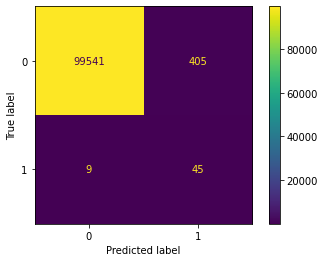

In [101]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format='d')

So, our model was able to only miss 9 out of the 54 fraudulents entries. Note that its precision was not as good (of the 450 fraudulent predictions, only 45 are indeed frauds), but, if we take the entire dataset into consideration, very few entries were deemed fraudulent wrongfully (only 0.4% of the non-fraudulent entries were guessed wrong).

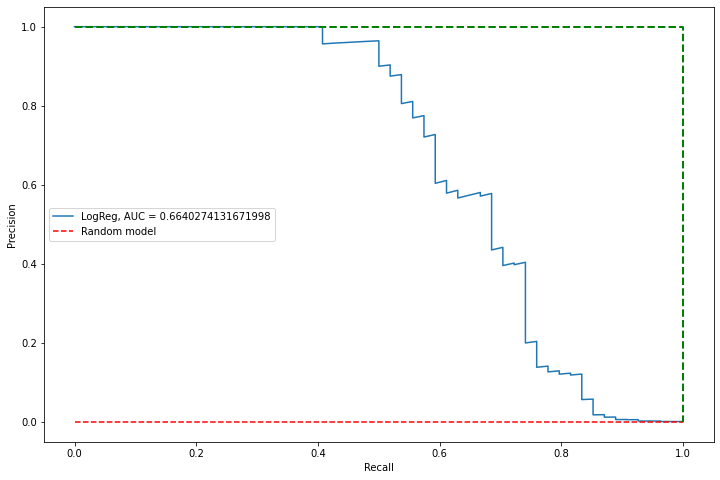

In [102]:
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'LogReg, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'Random model')
plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

## Deploying our model

So, we have defined that we will use the Catboost to detect frauds in our dataset. Now, we can deploy our model by serializing it. This way, we get a file that we can send to other people so that they can use our model (without needing to rebuild it):

In [103]:
output = open('FraudDetect_OptCatBoost.sav', 'wb')
pickle.dump( opt_cat_model, output )
output.close( )

Nice! In another moment, we will test this model using the entire dataset (remember that, for experimentation purposes, we are only using 100,000 entries from the dataset from Kaggle). Then, we can simply import the model file produced using pickle!

## Creating an interactive simulator on Python

Finally, to end things up, we can try to create an interactive simulator so that one can test different entries, and see if the model suspects it is a fraud. We can do that using:

In [104]:
amount_text   = widgets.FloatText(description = 'Amount: ')
old_orig_text = widgets.FloatText(description = 'Old (Origin): ')
new_orig_text = widgets.FloatText(description = 'New (Origin): ')
old_dest_text = widgets.FloatText(description = 'Old (Destiny): ')
new_dest_text = widgets.FloatText(description = 'New (Destiny): ')
type_text     = widgets.RadioButtons(description = 'Type', 
                                     options = ['Payment', 'Transfer', 'Debit', 'Cash-in', 'Cash-out'])

button = widgets.Button(description = 'Detect')

left  = VBox([amount_text, old_orig_text, new_orig_text, old_dest_text, new_dest_text])
right = VBox([type_text])
inputs = HBox([left, right])

Now, let's create a funciont to perform the prediction considering a given threshold:

In [110]:
def predict_thresh(X_v, t):
  y_prob = opt_cat_model.predict_proba(X_v)[::, 1].round(2)
  if y_prob < t:
    y_pred = 0
  else:
    y_pred = 1
  return (y_pred, y_prob)

In [111]:
def detect(sender):
  amount   = float(amount_text.value)
  old_orig = float(old_orig_text.value)
  new_orig = float(new_orig_text.value)
  old_dest = float(old_dest_text.value)
  new_dest = float(new_dest_text.value)
  transaction_type = str(type_text.value)

  type_payment  = 0
  type_transfer = 0
  type_debit    = 0
  type_cash_in  = 0
  type_cash_out = 0

  if transaction_type == 'Payment':
    type_payment = 1
  elif transaction_type == 'Transfer':
    type_transfer = 1
  elif transaction_type == 'Debit':
    type_debit = 1
  elif transaction_type == 'Cash-in':
    type_cash_in = 1
  elif transaction_type == 'Cash-out':
    type_cash_out = 1

  X_v = pd.DataFrame( {'amount' : amount, 'oldbalanceOrg' : old_orig, 'newbalanceOrig' : new_orig,
                           'oldbalanceDest' : old_dest, 'newbalanceDest' : new_dest, 
                           'type_CASH_IN' : type_cash_in, 'type_CASH_OUT' : type_cash_out, 'type_DEBIT' : type_debit,
                           'type_PAYMENT' : type_payment, 'type_TRANSFER' : type_transfer}, 
                            index = [0] )
  
  opt_thresh = df_metrics.loc['Optimal Catboost', 'threshold']
  y_pred, y_prob = predict_thresh(X_v, opt_thresh)

  if y_pred[0] == 0:
    print(f'Transaction is not fraudulent (Probability of {y_prob[0]*100}%, threshold of {opt_thresh*100}%).')
  else:
    print(f'Transaction is fraudulent (Probability of {y_prob[0]*100}%, threshold of {opt_thresh*100}%).')

In [107]:
button.on_click(detect)

In [108]:
display(inputs, button)

Button(description='Detect', style=ButtonStyle())

Nice! Now, we can use this interactive simulator to test different entries, and check if the model predicts that the transaction is fraudulent or not.

# Final recommendations

Finally, we managed to create a very strong fraud detection model for online payments. While our model has a precision close to 10%, which means that only 10% of the "predicted" frauds are, indeed, frauds, it has a very high recall, which means that, from the transactions that are real frauds, our model can find almost all of them. 

Now, we have to use the model to bring value to our business. Thus, we can propose some actions based on the model charactheristics, as well as based on the data itself. These recommendations are stated in the following:

* Usually, fraudulent transactions involve more money than usual transactions. Also, they usually involve accounts with very little balance (both in destiny and origin). Thus, we really should try to identify high-value transactions and, at least, make it more difficult to perform them, by requiring some validation tools (such as passwords, captchas, and biometry). 
* Also, most frauds involve transfers and cash-outs. Thus, this "increased security" may only affect those transactions, so that we don't introduce too much unnecessary red tape into our service.
* Since our model has a very high recall, we can use it to identify which transactions really need this increased security. In cases where we are really unsure about the authenticity of a given transaction, we can even require the person to go to a physical place to confirm the transaction.
* Note that, even though our model has high recall, it has a low precision: only about 10% of the predicted frauds are, indeed, frauds. Thus, we should make it more difficult to perform these transactions, but not impossible. Otherwise, we run the risk of losing potential customers. That being said, only a very small fraction of the non-fraudulent transactions will fall into this.

These are important recommendations for the company, and may be used to guide further implementations in the service.


